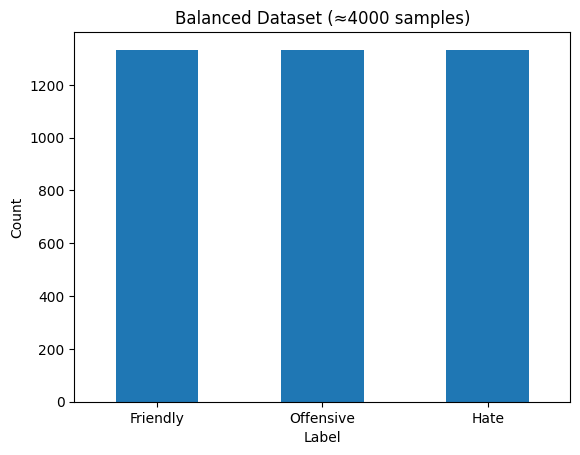

                                               tweet  label
0                        Breezy gotta sleep this hoe      1
1  @BraxCity29 @maria_obregon_g @sophia_freeman1 ...      2
2  If a bitch don't like me, sumthin wrong wit da...      1
3     @BeyondTomcat you'd like that wouldn't you fag      2
4                    Wish I got hoes like James Bond      1


In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# === STEP 1: Load Davidson Dataset ===
df_hate = pd.read_csv("labeled_data.csv")

# Remap class: 0 → 2 (hate), 1 → 1 (offensive), 2 → 0 (friendly)
df_hate['label'] = df_hate['class'].map({0: 2, 1: 1, 2: 0})
df_hate = df_hate[['tweet', 'label']]

# === STEP 2: Load DailyDialog Files ===
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("validation.csv")

# Extract friendly utterances
def extract_utterances_from_dialog_column(df):
    all_utterances = []
    for dialog_str in df['dialog'].dropna():
        try:
            utterances = ast.literal_eval(dialog_str)
            if isinstance(utterances, list):
                all_utterances.extend([utt.strip() for utt in utterances if len(utt.strip()) > 3])
        except Exception:
            continue
    return all_utterances

utterances = (
    extract_utterances_from_dialog_column(df_train) +
    extract_utterances_from_dialog_column(df_test) +
    extract_utterances_from_dialog_column(df_val)
)

df_pos = pd.DataFrame({
    'tweet': utterances,
    'label': 0  # Friendly
})

# === STEP 3: Combine and Balance to 4000 samples (≈1333/class) ===
df_all = pd.concat([df_hate, df_pos], ignore_index=True)

target_count = 1333

# Sanity check: Do we have enough samples per class?
label_counts = df_all['label'].value_counts()
for label in [0, 1, 2]:
    if label_counts[label] < target_count:
        raise ValueError(f" Not enough samples for label {label}: only {label_counts[label]} available.")

# Sample and balance
df_balanced = pd.concat([
    df_all[df_all['label'] == 0].sample(target_count, random_state=42),
    df_all[df_all['label'] == 1].sample(target_count, random_state=42),
    df_all[df_all['label'] == 2].sample(target_count, random_state=42)
], ignore_index=True)

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# === STEP 4: Visualize
df_balanced['label'].value_counts().plot(kind='bar')
plt.title("Balanced Dataset (≈4000 samples)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Friendly", "Offensive", "Hate"], rotation=0)
plt.show()

# === STEP 5: Preview and Save
print(df_balanced.head())
df_balanced.to_csv("balanced_dataset.csv", index=False)


In [2]:
pip install transformers datasets scikit-learn torch


In [3]:
import pandas as pd

# Load the balanced data
df = pd.read_csv("balanced_dataset.csv")

# Optional: Rename columns just in case
df = df.rename(columns={'tweet': 'text', 'label': 'label'})

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
texts = df["text"].tolist()
labels = df["label"].tolist()

encodings = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
import torch
from torch.utils.data import Dataset

class HateDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

dataset = HateDataset(encodings, labels)


In [6]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [7]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW
import torch

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from tqdm import tqdm

model.train()
for epoch in range(10):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())


Epoch 9: 100%|██████████| 200/200 [01:07<00:00,  2.97it/s, loss=0.0198]


In [9]:
from sklearn.metrics import classification_report

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

print(classification_report(true_labels, preds, target_names=["Friendly", "Offensive", "Hate"]))


              precision    recall  f1-score   support

    Friendly       0.95      0.90      0.92       274
   Offensive       0.78      0.80      0.79       282
        Hate       0.73      0.75      0.74       244

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



In [10]:
model.save_pretrained("hate_detector_model/")
tokenizer.save_pretrained("hate_detector_model/")

('hate_detector_model/tokenizer_config.json',
 'hate_detector_model/special_tokens_map.json',
 'hate_detector_model/vocab.txt',
 'hate_detector_model/added_tokens.json')

In [11]:
pip install openai-whisper

In [16]:
import whisper
whisper_model = whisper.load_model("base")


In [17]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("hate_detector_model")
tokenizer = BertTokenizer.from_pretrained("hate_detector_model")
model.eval()

# Prediction function
def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return ["Friendly", "Offensive", "Hate"][pred]


In [40]:
audio_path = "102.m4a"

result = whisper_model.transcribe(audio_path, language="en")
text = result["text"]
label = predict_label(text)

print("Transcribed:", text)
print("Predicted Label:", label)


Transcribed:  Hi, how are you?
Predicted Label: Friendly


In [41]:
# Save the trained model state dictionary
torch.save(model.state_dict(), 'nlp_hate_detector_model.pth')

In [43]:
# Load the saved state dictionary
model_state_dict = torch.load('nlp_hate_detector_model.pth', map_location=torch.device('cpu')) # or 'cuda' if you trained on GPU and want to load on GPU

# Load the model structure first
loaded_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

# Load the state dictionary into the model
loaded_model.load_state_dict(model_state_dict)

# Move the loaded model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully from hate_detector_model.pth")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully from hate_detector_model.pth


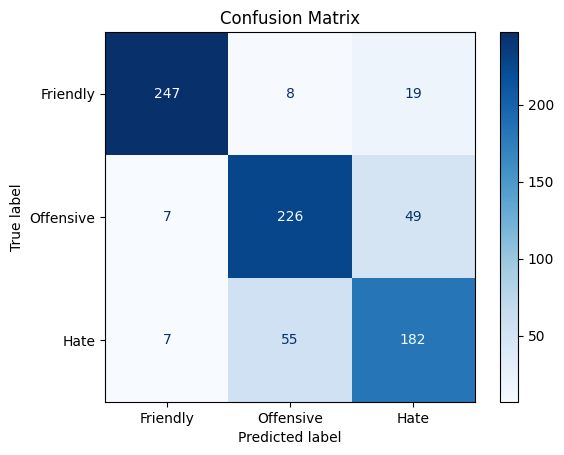

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Friendly", "Offensive", "Hate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [45]:
from google.colab import files
files.download('nlp_hate_detector_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>